In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
from functools import singledispatch, wraps
from inspect import getcallargs
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from asterism.base import buildmethod, checkmethod, Asterism
from asterism.utils import get_kwargs, kmeans, relabel
from asterism.utils.acts import Dirichlet
from asterism.utils.data import make_dataset
from asterism.utils.nets import ACT, OPTIM, Encoder, MLP
from asterism.utils.figs import show_dataset

In [119]:
class RNN(nn.Module):
    def __init__(self, channels, bias=True, act_layer='relu'):
        super().__init__()

        self.channels = channels
        
        self._model = nn.RNN(self.channels, self.channels, nonlinearity=act_layer, bias=bias)
        self._x = torch.rand(1, channels)

    def forward(self, n_passes=1, x=None):
        if x is None:
            x = self._x

        for i in range(1, n_passes):
            x = torch.cat([x, self._model(x[i - 1:i])[0]])

        return x
    
class RSB(Asterism, nn.Module):
    def __init__(self, min_topics=2, *, channels=(64, 32), kld_scale=1., optim='adam', desc='RSB', seed=None):
        super().__init__(desc, seed)

        self.min_topics = min_topics
        self.channels = channels
        self.kld_scale = kld_scale
        self.optim = optim

        self._n_steps = 100
        self.topic_log_ = []

    def _build(self, X, fit_rate=1e-2, batch_size=128, shuffle=True):
        self._batch_size, in_channels = batch_size, X.shape[-1]
        self._loader = DataLoader(X, self._batch_size, shuffle)
        self._encoder = Encoder(in_channels, *self.channels, act_layer='prelu')
        self._dt_model, self._tw_model = RNN(self.channels[-1]), RNN(self.channels[-1])
        self._decoder, self._softmax = MLP(self.channels[-1], in_channels), nn.Softmax(-1)
        self._optim = OPTIM[self.optim](self.parameters(), lr=fit_rate)
        self.train()

        return self
    
    def _generate(self, z=None, n_topics=None):
        if n_topics is None:
            n_topics = self.n_topics_

        tw_probs = self._decoder(self._tw_model(n_topics))

        if z is not None:
            dt_probs = self._softmax(z@self._dt_model(n_topics).T)
            X = dt_probs@tw_probs

            return X
        return tw_probs
    
    def _evaluate(self, X):
        z, kld = self._encoder(X, return_kld=True)
        Xk, XK = self._generate(z, self.n_topics_ - 1), self._generate(z)
        lossk, lossK = .5*(Xk - X).square().sum(-1), .5*(XK - X).square().sum(-1)

        if (lossk - lossK).sum()/lossK.sum() > .2:
            self.n_topics_ += 1

        loss = lossK.sum() + self.kld_scale*kld

        return loss
    
    def _step(self):
        self.n_topics_, loss = self.min_topics, 0.

        for x in self._loader:
            x_loss = self._evaluate(x)
            x_loss.backward()
            loss += x_loss.item()

        self._optim.step()
        self._optim.zero_grad()
        self.topic_log_.append(self.n_topics_)

        return loss
    
    def _predict(self, X, eval=True):
        if eval:
            self.eval()

        # z, dt_props = self._encoder(X), self._dt_model(self.n_topics_)
        # topics = self._softmax(z@dt_props.T).argmax(-1).detach()
        topics = (X@self._generate().T).argmax(-1).detach()

        return topics

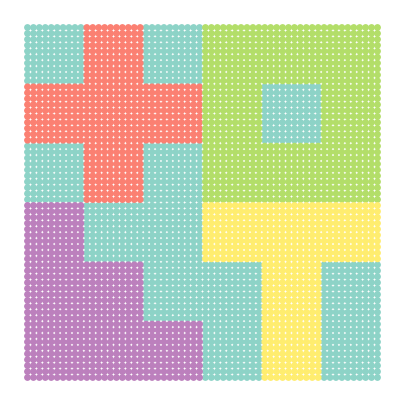

In [120]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

In [121]:
model.n_topics_

6

RSB: 100%|██████████| 1000/1000 [00:44<00:00, 22.61it/s]


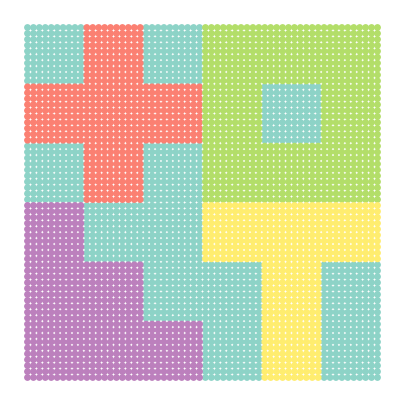

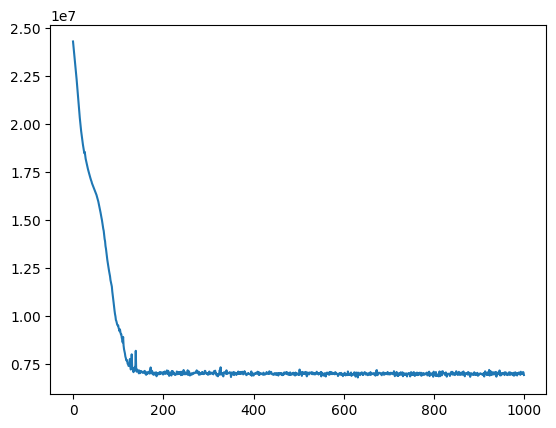

In [122]:
model = RSB(2)
topics = model.fit_predict(data[:, 3:], n_steps=1000, fit_rate=1e-2)
show_dataset(data, topics)
plt.plot(range(len(model.log_)), model.log_)
plt.show()

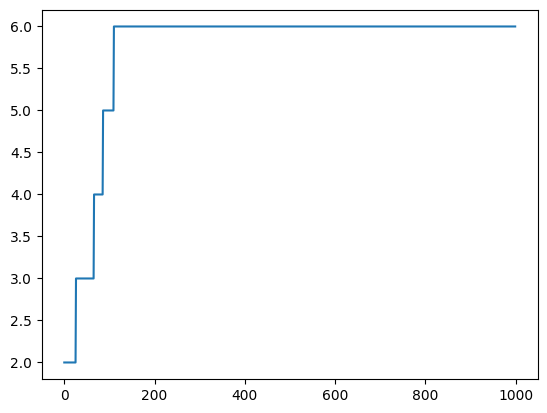

In [123]:
plt.plot(range(len(model.topic_log_)), model.topic_log_)